# Step4 演習03 MNISTの分類
---

本演習では、TensorFlowを用いてMNISTの分類をおこないます。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- TensorFlowの基本的な関数を用いてCNNを構築する
- MNISTを用いて１０クラス分類問題を解く
- パラメータの初期化方法、L2正則化の方法を学ぶ

**【課題１】** 採点を実行してください。

In [1]:
#Coursedele-02 Step4 QuestionNumber12 4b1d36da3cebc964d7b02692415089b4
print("この課題の採点は全員正解とします。")

この課題の採点は全員正解とします。


** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [2]:
%%bash
./validation_client.py dele-02 4 12 Step4_03.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



# 1 Tensorflow

## 1-1 ライブラリのインポート

まずはじめに、本演習で利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [tensorflow](https://www.tensorflow.org/) 機械学習用のライブラリの公式ドキュメント

`%matplotlib inline` はnotebook上で使える[magic function](http://ipython.readthedocs.io/en/stable/interactive/magics.html)の一つで、これによりmatplotlibをインタラクティブに使うことできます。

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## 1-2 データセット
過去のStep同様にここでもMNISTデータ・セットを使います。

MNISTのダウンロード元のURLを用意します。

In [4]:
mnist_ulr = 'http://yann.lecun.com/exdb/mnist/'

MNISTのダウンロードと読み込みを行います。read_data_setsの引数は
- ファイルの保存場所
- one_hot: one-hotベクトル化するかどうか
- validation_size: 検証用データの枚数、今回は訓練データとテストデータのみ使用します
- source_url: データセットのダウンロード元

In [5]:
mnist = input_data.read_data_sets("MNIST_data/",
                                  one_hot=True,
                                  validation_size=0,
                                  source_url=mnist_ulr)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


この`mnist`は少し複雑な形式で入っています。学習データの画像とラベルにアクセスするには、


`mnist.train.images`


`mnist.train.labels`

とします。`train`の部分を`test`にすることでテストデータにアクセスできます。注意しなければならないのは、`mnist`の中の画像やラベルの値を変更したい場合は`_images`や`_labels`としなければなりません。

訓練データとテストデータのshapeを確認してみます。

In [6]:
print("訓練データ数：{}".format(mnist.train.images.shape[0]))
print("訓練データ数の特徴（ピクセル）：{}".format(mnist.train.images.shape[1]))
print("テストデータ数：{}".format(mnist.test.images.shape[0]))
print("テストデータ数の特徴（ピクセル）：{}".format(mnist.test.images.shape[1]))

訓練データ数：60000
訓練データ数の特徴（ピクセル）：784
テストデータ数：10000
テストデータ数の特徴（ピクセル）：784


ここで学習データの画像をランダムに表示させてみます。セルを実行するたびに画像が変わります。

Class: 7


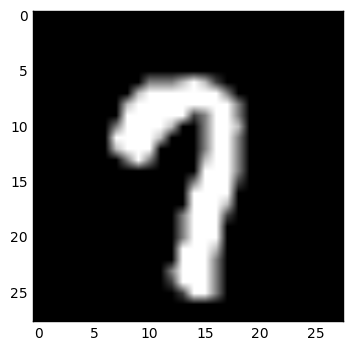

In [7]:
num = np.random.randint(0, len(mnist.train.images))
plt.imshow(mnist.train.images[num].reshape(28, 28), cmap='gray')
print('Class: {}'.format(np.argmax(mnist.train.labels[num])))

### 1-2-1 データセットのシャッフル

今回もデータ・セットを念の為シャッフルします。

In [8]:
permutation = np.random.permutation(mnist.train._images.shape[0])
mnist.train._images = mnist.train.images[permutation]
mnist.train._labels = mnist.train.labels[permutation]

### 1-2-2 データの制限

この演習では計算時間を削減するために、学習データとテストデータのサイズを制限します。

ここでは、
- 学習データは10,000枚
- テストデータは1,000枚

とします。

In [9]:
train_size = 10000
test_size = 1000
mnist.train._images = mnist.train.images[:train_size]
mnist.train._labels = mnist.train.labels[:train_size]
mnist.train._num_examples = train_size
mnist.test._images = mnist.test.images[:test_size]
mnist.test._labels = mnist.test.labels[:test_size]
mnist.test._num_examples = test_size

### 1-2-2 データセットの正規化

**【確認１】**　データ・セットを正規化する関数を実装します。

データセット全体が平均0.0，分散1.0となるように正規化します。
データ・セットを正規化する際はチャンネル単位で行いますが、MNISTはチャンネルが１つなので今回は気にする必要はありません。

In [10]:
###############START CODE HERE###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
mean = np.mean(mnist.train.images)
std = np.std(mnist.train.images)
mnist.train._images = (mnist.train.images-mean)/std
mnist.test._images = (mnist.test.images-mean)/std
################END CODE HERE################

## 1-3 CNNの構築

この演習では過学習を防ぐために使われるL2正則化を行います。L2正則化は、学習時の損失に、
$$\frac{1}{2}\lambda w^2$$
を追加します。ここで$\lambda$はL2正則化パラメータです。この演習では0.0001 (=1e-4)を用います。

In [11]:
WEIGHT_DECAY = 1e-4

### 1-3-1畳み込み層の作成

**【確認２】**　畳み込み処理をするために必要な関数を作成します。

ここでは畳み込み処理をするために必用な関数を作成します。`conv2d`は5つの引数があります。
- `x_tensor`: 入力テンソル（バッチサイズ、縦、横、チャネル）
- `num_outputs`: 出力チャネル数
- `ksize`: カーネル（フィルタ）サイズ
- `strides`: ストライド幅
- `padding`: SAME or VALID, SAMEの場合は入力サイズと出力サイズが等しくなるようにゼロパディングが行われます。（strideが2などの場合は基本的に出力サイズが半分になるように調整されます。）

そして、この関数内では、[tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)
に必要なものを用意します。
- `num_inputs`: `x_tensor.get_shape().as_list()`とすることでリスト形式で形を取得できます。ここから入力チャネル（`num_inputs`）だけを取得します。
- `conv_stride`は入力のどの次元にストライドを適用させるかリスト形式で用意します。
- `weight_shape`ではまず重みの形をリスト形式で指定します。（カーネルサイズ、カーネルサイズ、入力チャネル、出力チャネル）
- `conv_weight`は実際に重みを作成します。今回は[glorot_uniform](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)と呼ばれる方法で初期化します。これは一様分布で下限と上限を、
$$\pm\sqrt{\frac{6}{(fan\_in + fan\_out)}}$$
としたものです。ここで、$fan\_in$と$fan\_out$は、
$$fan\_in=input\_channel \times kernel\_size \times kernel\_size$$
$$fan\_out=output\_channel \times kernel\_size \times kernel\_size$$
です。ただし全結合層のようにカーネルがない場合は$kernel\_size$はいりません。tensorflowでは[tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform)で一様分布を生成できます。ここで、生成した配列を[tf.Variable](https://www.tensorflow.org/api_docs/python/tf/Variable)で囲むの忘れないようにしましょう。これによりtensorflowのグラフにこの配列が追加されます。

最後に[tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)に`x_tensor`, `conv_weight`, `conv_strides`, `padding`を渡し`conv`が完成します。引数の渡す順番や引数名は[tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)で確認しましょう。

畳み込み処理は終わりましたがまだバイアスとL2正則化の準備が終わっていないのでこれも行います。
- `biases`でバイアスを用意します。バイアスは[tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)で出力チャネル分ゼロに初期化します。
- `conv_bias`: 作成した`biases`を`conv`に追加します。これには、[tf.nn.bias_add](https://www.tensorflow.org/api_docs/python/tf/nn/bias_add)を使用します。
- `l2_loss`: 次に[tf.nn.l2_loss](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss)を用いて`conv_weight`のL2正則化ロスを計算します。ここで`WEIGHT_DECAY`を掛けるのを忘れないようにしてください。
- 最後に計算した`l2_loss`を[tf.add_to_collection](https://www.tensorflow.org/api_docs/python/tf/add_to_collection)に追加します。これはpythonのクラスのようなもので、これを使うことでグラフ内の任意の箇所で値を追加/取得することができます。

In [12]:
def conv2d(x_tensor, num_outputs, ksize, strides, padding='SAME'):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    # x_tensor: [batch_size, height, width, channel]
    # 入力チャネルの取得
    num_inputs = x_tensor.get_shape().as_list()[-1]
    # 入力のどの次元に、どれだけストライドを適用させるか
    conv_strides = [1, strides, strides, 1]
    # カーネル（フィルタ、重み）の形を指定
    weight_shape = [ksize, ksize, num_inputs, num_outputs]
    # 重みの初期化
    fan_in = num_inputs * ksize * ksize
    fan_out = num_outputs * ksize * ksize
    std = np.sqrt(6. / (fan_in + fan_out))
    conv_weight = tf.Variable(tf.random_uniform(weight_shape,
                                                minval=-std,
                                                maxval=std))
    #　入力テンソルに畳み込み処理を施す
    conv = tf.nn.conv2d(
        x_tensor,
        filter=conv_weight,
        strides=conv_strides,
        padding=padding)
    # バイアスの初期化（ゼロで初期化します）
    biases = tf.Variable(tf.zeros(num_outputs))
    # 畳み込みにバイアスを追加
    conv_bias = tf.nn.bias_add(conv, biases)
    # L2正則化
    l2_loss = tf.nn.l2_loss(conv_weight) * WEIGHT_DECAY
    # collectionにL2正則化ロスを追加
    tf.add_to_collection('costs', l2_loss)
    ################END CODE HERE################
    return conv_bias

### 1-3-2プーリング層の作成

**【確認３】**　次にプーリング処理をするために必要な関数を作成します。

ここでは最大プーリング処理をするために必用な関数を作成します。`maxpool`は5つの引数があります。
- `x_tensor`: 入力テンソル（バッチサイズ、縦、横、チャネル）
- `ksizes`: カーネル（フィルタ）サイズ
- `strides`: ストライド幅
- `padding`: SAME or VALID, SAMEの場合は入力サイズと出力サイズが等しくなるようにゼロパディングが行われます。（strideが2などの場合は基本的に出力サイズが半分になるように調整されます。）

そして、この関数内では、[tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)
に必要なものを用意します。
- `maxpool_strides`は入力のどの次元にストライドを適用させるかリスト形式で用意します。
- `maxpool_filter`は入力のどの次元にフィルタを適用させるかリスト形式で用意します。

最後に[tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)に`x_tensor`, `maxpool_strides`, `maxpool_stride`, `padding`を渡し`maxpool`が完成します。引数の渡す順番や引数名は[tf.nn.max_pool](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)で確認しましょう。

In [13]:
def maxpool(x_tensor, ksize, strides=2, padding='SAME'):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    # 入力のどの次元に、どれだけストライドを適用させるか
    maxpool_strides = [1, strides, strides, 1]
    # 入力のどの次元に、どれだけフィルターを適用させるか
    maxpool_filter = [1, ksize, ksize, 1]
    #　入力テンソルにプーリング処理を施す
    maxpool = tf.nn.max_pool(x_tensor,
                             ksize=maxpool_filter,
                             strides=maxpool_strides,
                             padding=padding)
    ################END CODE HERE################
    return maxpool

### 1-3-3 入力の平滑化

**【確認４】**　4Dテンソルを2Dテンソルに変換するための関数`flatten`を実装します。

ここではまず入力テンソルの形を取得し、[tf.reshape](https://www.tensorflow.org/api_docs/python/tf/reshape)で（-1、縦×横×チャネル）に変形させます。

In [14]:
def flatten(x_tensor):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    # 入力テンソルの形を取得
    b, h, w, c = x_tensor.get_shape().as_list()
    x_tensor_reshaped = tf.reshape(x_tensor, [-1, h * w * c])
    ################END CODE HERE################
    return x_tensor_reshaped

### 1-3-4全結合層の作成

**【確認５】**　全結合層を作成します。

ここでは全結合層の処理に必用な関数を作成します。`fc`は2つの引数があります。
- `x_tensor`: 入力テンソル（バッチサイズ、縦、横、チャネル）
- `num_outputs`: 出力チャネル数

そして、この関数内では、[tf.nn.xw_plus_b](https://www.tensorflow.org/api_docs/python/tf/nn/xw_plus_b)
に必要なものを用意します。
- `num_inputs`: 入力チャネルを`x_tensor`から取得します。
- `weight_shape`ではまず重みの形をリスト形式で指定します。（入力チャネル、出力チャネル）
- `fc_weights`は実際に重みを作成します。`conv2d`と同様に[glorot_uniform](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)で初期化します。今回は全結合層なので、$fan\_in$と$fan\_out$に$kernel\_size$はいりません。
- `biases`でバイアスを用意します。バイアスは[tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)で出力チャネル分ゼロに初期化します。

最後に[tf.nn.xw_plus_b](https://www.tensorflow.org/api_docs/python/tf/nn/xw_plus_b)に`x_tensor`, `fc_weights`, `biases`を渡し、全結合層の完成です。

畳み込み処理同様にL2正則化も行います。

In [15]:
def fc(x_tensor, num_outputs):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    # 入力チャネルを取得
    num_inputs = x_tensor.get_shape().as_list()[-1]
    # 重みの形を指定
    weight_shape = [num_inputs, num_outputs]
    # 重みの初期化
    fan_in = num_inputs
    fan_out = num_outputs
    std = np.sqrt(6. / (fan_in + fan_out))
    fc_weights = tf.Variable(tf.random_uniform(weight_shape,
                                               minval=-std,
                                               maxval=std))
    # バイアスの初期化
    biases = tf.Variable(tf.zeros(num_outputs))
    # 入力テンソルに重みをかけてバイアスを足す
    fc_bias = tf.nn.xw_plus_b(x_tensor, fc_weights, biases)
    # 畳み込みと同様にL2正則化
    l2_loss = tf.nn.l2_loss(fc_weights) * WEIGHT_DECAY
    # collectionにL2正則化を追加
    tf.add_to_collection('costs', l2_loss)
    ################END CODE HERE################
    return fc_bias

### 1-3-5 CNNモデルの構築

**【確認６】**　CNNモデルを構築します。

CNNの構造をここで決定します。

`CNN`は2つの引数があります。
- `x`: 入力画像（バッチサイズ、縦×横=28×28)
- `keep_prob`: ドロップアウトしない確率

- 入力テンソルを（バッチサイズ、28,28,1）となるように変換
- カーネルサイズ：３、フィルター数：１６、ストライド：１の畳み込み層
- 活性化関数（ここでは[tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu)を使ってください）
- フィルターサイズ：２，ストライド：２のプーリング層
- カーネルサイズ：３、フィルター数：３２、ストライド：１の畳み込み層
- 活性化関数：ReLU
- 入力テンソルを２Dに変換
- ノード数１２８の全結合層
- 活性化関数：ReLU
- ドロップアウト: [tf.nn.dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)を使います。`keep_prob`を渡すのを忘れないでください。
- ノード数１０の全結合層
- ソフトマックスとコスト関数と同時に行うのでここでは全結合層の出力を`cnn`の戻り値とします。

In [25]:
def cnn(x, keep_prob):
    ###############START CODE HERE###############
    #適切な 関数・変数・値 などにNoneを書き換えてください。
    x = tf.reshape(x, (-1, 28, 28, 1))
    x = conv2d(x, 16, 3, 1)
    x = tf.nn.relu(x)
    x = maxpool(x, 2, 2)  # 28x28 -> 14x14
    x = conv2d(x, 32, 3, 1)
    x = tf.nn.relu(x)
    x = flatten(x)
    x = fc(x, 128)
    x = tf.nn.dropout(x, keep_prob)
    x = tf.nn.relu(x)
    x = fc(x, 10)
    ################END CODE HERE################
    return x

## 1-4 CNNの学習の準備

### 1-4-1 placeholderの準備

この演習では４つのplaceholderを用意します。
- `images`: 入力画像、shapeは(None, 28 * 28)です。Noneはミニバッチの次元です。
- `labels`: クラスラベル、shapeは(None, 10)です。
- `keep_prob`: ドロップアウトをしない確率
- `learning_rate`: 学習率

In [26]:
# Prepare placeholders
tf.reset_default_graph()
keep_prob = tf.placeholder(dtype=tf.float32, shape=())
images = tf.placeholder(dtype=tf.float32, shape=(None, 28 * 28))
labels = tf.placeholder(dtype=tf.int64, shape=(None, 10))
learning_rate = tf.placeholder(dtype=tf.float32, shape=())

### 1-4-2 CNNの読み込み

**【確認７】**

- `logits`: `cnn`に`image`と`keep_prob`を渡します。
- `test_pred`: テスト画像はロス関数には渡さず[tf.nn.softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax)を適用させます。

In [27]:
###############START CODE HERE###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
logits = cnn(images, keep_prob)
test_pred = tf.nn.softmax(logits)
################END CODE HERE################

### 1-4-3 コスト関数の定義

**【確認８】**　ここでは、コスト関数を定義します。

コスト関数にクロスエントロピー誤差関数を使用します。
- `cost`: ここでは [tf.nn.softmax_cross_entropy_with_logits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits) を使用します。また、このままではクラス分の損失があるので [tf.reduce.mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) を使って平均を求めます。
- この`cost`も[tf.add_to_collection](https://www.tensorflow.org/api_docs/python/tf/add_to_collection)を使ってcollectionに追加します。
- `costs`: これまでcollectionに渡したcostsを[tf.get_collection](https://www.tensorflow.org/api_docs/python/tf/get_collection)を使って取得し、[tf.add_n](https://www.tensorflow.org/api_docs/python/tf/add_n)を使いすべて足し合わせます。

In [28]:
###############START CODE HERE###############
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=labels))
tf.add_to_collection('costs', cost)
costs = tf.add_n(tf.get_collection('costs'))
################END CODE HERE################

### 1-4-4 最適化

**【確認９】** 定義した損失関数をAdamで最適化します。

- `optimizer`: [tf.train.AdamOptimzer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)を追加します。引数には`learning_rate`を渡します。また、これを`.minimize(costs)`を後尾に書き加えます。

In [30]:
###############START CODE HERE###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(costs)
################END CODE HERE################

### 1-4-5 精度の計算

**【確認１０】** ここでは精度を計算します。

- `correct_pred`: [tf.equal](https://www.tensorflow.org/api_docs/python/tf/equal)を使い予測結果の`test_pred`と正解ラベルの`labels`を比較します。この際に、まず両方とも[tf.argmax](https://www.tensorflow.org/api_docs/python/tf/argmax)を使いone-hot-vectorの最大値のインデックスを返させます。ここで、`axis=1`とするのを忘れないようにしてください。
- `accuracy`: `correct_pred`はbool型（[True, False, True...])となっているので[tf.cast](https://www.tensorflow.org/api_docs/python/tf/cast)を使ってtf.float32に変換させます。そして、[tf.reduce_mean](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)を使って精度を求めます。

In [31]:
###############START CODE HERE###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
correct_pred = tf.equal(tf.argmax(test_pred, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
################END CODE HERE################

## 1-5 学習

**【確認１１】** ここではいよいよCNNを学習させてみます。ここでミニバッチサイズを200にして3エポック学習します。

セルのはじめに`%%time`と書くとそのセルを実行するのにかかった時間を最後に表示してくれます。`%%timeit`とするとセルを複数回実行し平均時間を求めてくれます。(magic functionの一つです）

In [32]:
%%time
# ミニバッチを指定
batch_size = 200
# 学習させるエポック数を指定
total_epoch = 3
# 学習データのサイズ
train_size = len(mnist.train.images)
# テストデータのサイズ
test_size = len(mnist.test.images)
# 1エポックあたりのステップ数
total_step_train = int(train_size / batch_size)
# 学習率
lr = 0.001
# ロス/精度を記録するための配列
train_cost = []
train_acc = []
test_cost = []
# sessionを作成
with tf.Session() as sess:
    # variablesを初期化
    sess.run(tf.global_variables_initializer())
    for epoch in range(total_epoch):  # total_epoch数分ループ
        ### 学習 ###
        for step in range(total_step_train):  # total_step_train数分ループ
            # .next_batchで新しいミニバッチを取得（これは実行するたびに次のミニバッチを取得できます）
            batch = mnist.train.next_batch(batch_size, shuffle=False)

            # sessを実行（ここではoptimizerとcostsとaccuracyを渡します。またfeed_dictでは辞書型でplaceholderに値を渡します。
            # ここではkeep_probは0.5とします。）
            ###############START CODE HERE###############
            #適切な 関数・変数・値 などにNoneを書き換えてください。
            _, _cost, _acc = sess.run([optimizer, costs, accuracy],
                                feed_dict={images: batch[0],
                                           labels: batch[1],
                                           keep_prob: 0.5,
                                           learning_rate: lr})
            ################END CODE HERE################
            print('\r \t {}/{} cost: {:.3f}'.format(step + 1, total_step_train, _cost), end='')
            # 配列に_costと_accを追加
            train_cost.append(_cost)
            train_acc.append(_acc)
        # エポックの平均ロスを計算
        train_cost_mean = np.mean(train_cost[-total_step_train:])
        ### テスト ###
        print('\r Calculating for test dataset', end='')
        ###############START CODE HERE###############
        #適切な 関数・変数・値 などにNoneを書き換えてください。
        test_cost, test_acc = sess.run([cost, accuracy],
                                       feed_dict={images: mnist.test.images,
                                                  labels: mnist.test.labels,
                                                  keep_prob: 1.0})
        ################END CODE HERE################
        # エポック毎にログをプリント
        print('\r Epoch: {}, Train cost (epoch mean): {:.3f}, Test cost: {:.3f}, Test Acc: {:.3f}'.format(
                epoch, train_cost_mean, test_cost, test_acc))

 Epoch: 0, Train cost (epoch mean): 0.640, Test cost: 0.205, Test Acc: 0.933
 Epoch: 1, Train cost (epoch mean): 0.233, Test cost: 0.124, Test Acc: 0.962
 Epoch: 2, Train cost (epoch mean): 0.158, Test cost: 0.089, Test Acc: 0.970
CPU times: user 51.8 s, sys: 8.58 s, total: 1min
Wall time: 33.4 s


今回は非常に小さなCNNで３エポックしか学習していないのでテスト精度は80%ちょっとだと思います。

最後に学習ロスと学習精度をプロットしてみます。ロスは下がり、精度は上がっているのが確認できると思います。

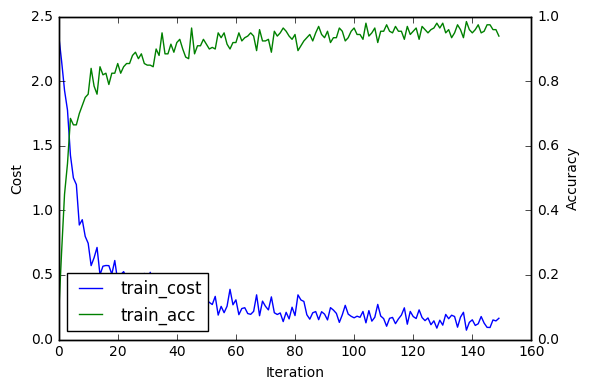

In [33]:
fig, ax1 = plt.subplots()
lns1 = ax1.plot(train_cost, label='train_cost', color='b')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Cost')
ax2 = ax1.twinx()
lns2 = ax2.plot(train_acc, label='train_acc', color='g')
ax2.set_ylabel('Accuracy')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=3)
fig.tight_layout()